***

*Course:* [Math 444](https://people.math.wisc.edu/~hlyu36/GNiDS/) - Graphs and Networks in Data Science (MMiDS) - Spring 2025

*Author:* [Hanbaek Lyu](https://hanbaeklyu.com), Department of Mathematics, University of Wisconsin-Madison  

***

# Graph Neural Network experiments for node classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch torchvision torchaudio torch-geometric --quiet

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import numpy as np

## CORA Citation Network

In [11]:
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

print(f"Dataset: {dataset}:")
print(f" - Number of graphs: {len(dataset)}")
print(f" - Number of features: {dataset.num_features}")
print(f" - Number of classes: {dataset.num_classes}")

G = nx.Graph()
edge_index = data.edge_index.numpy()
G.add_edges_from(edge_index.T)

Dataset: Cora():
 - Number of graphs: 1
 - Number of features: 1433
 - Number of classes: 7


In [8]:
# Initialize graph
G = nx.Graph()

path = "/content/drive/My Drive/Senior Year/Spring 2025/Math 444/Data/cora_edges.txt"
edgelist = list(np.genfromtxt(path, delimiter=",", dtype=str))

# Add in all edges in the edgelist to G
for e in edgelist:
    G.add_edge(e[0], e[1])

path_classes = "/content/drive/My Drive/Senior Year/Spring 2025/Math 444/Data/cora_node_labels.txt"
node_labels = list(np.genfromtxt(path_classes, delimiter=",", dtype=int))

node_labels_dict = {}
for i in np.arange(len(node_labels)):
    node_labels_dict.update({str(node_labels[i][0]): node_labels[i][1]-1})

y = []
for v in G.nodes():
    y.append(node_labels_dict.get(v))

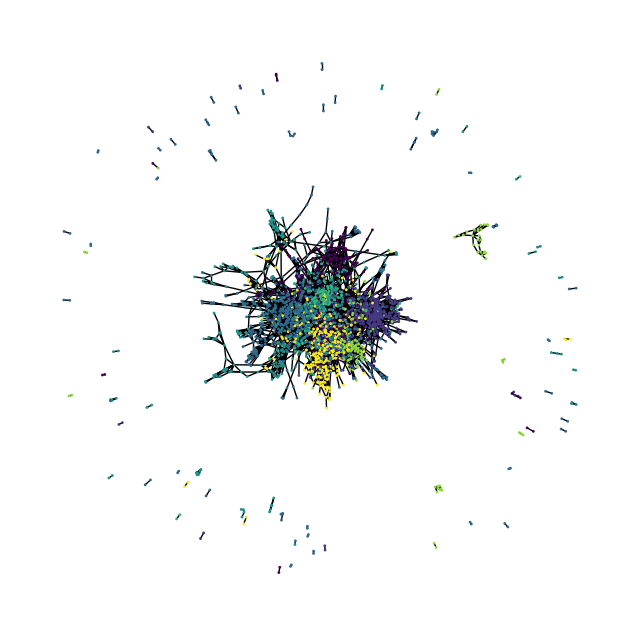

In [9]:
# plot the graph
fig = plt.figure(figsize=[8,8], constrained_layout=False)
ax = fig.add_subplot()
nx.draw_networkx(G, ax=ax, pos=nx.spring_layout(G), labels={},
                 node_size=1, node_color=y, font_size=14, font_color="white")
plt.axis('off');
plt.savefig("cora_graph", bbox_inches="tight")

## DeepWalk node embedding

In [5]:
def RW(G, x0=None, steps=1, return_history=False):
    # simple symmetric random walk on graph G
    # initialization at x0
    if x0 is None:
        x = np.random.choice(G.nodes())
    else:
        x = x0

    history = []
    for i in np.arange(steps):
        if len(list(G.neighbors(x))) == 0:
            print("RW is stuck at isolated node")
            x = np.random.choice(G.nodes()) # re-initialize uniformly at random
        else:
            x = np.random.choice(list(G.neighbors(x)))

        if return_history:
            history.append(x)

    if not return_history:
        return x
    else:
        return history


def learn_embeddings(walks, args, verbose=False):
    from gensim.models import Word2Vec
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks_str = []
    for walk in walks:
        walks_str.append([str(x) for x in walk])

    model = Word2Vec(walks_str,
                     vector_size=args.get("emb_dim"),
                     window=args.get("window_size"),
                     min_count=0, sg=1,
                     workers=args.get("workers"),
                     epochs=200)
    model.wv.save_word2vec_format(args.get("output"))

    # Store just the words + their trained embeddings as a numpy dictionary
    word_vectors = model.wv
    my_dict = dict({})
    keys = []
    for idx, key in enumerate(model.wv.key_to_index):
        my_dict[key] = model.wv[key]

    if verbose:
        # print("motifs embedded : {}".format(my_dict.keys()))
        for word in my_dict.keys():
            print("node \n {} ===> emb {}".format(word, my_dict.get(word)))
    # self.sort_dict(my_dict)
    return my_dict

In [10]:
args = {}
args.update({"weighted" : False})
args.update({"directed" : False})
args.update({"emb_dim" : 20})
args.update({"output" : "test_DeepWalk.txt"})
args.update({"walk_length" : 10})
args.update({"num_walks" : 2})
args.update({"window_size" : 10})
args.update({"SGD_iter" : 50})
args.update({"workers" : 8})


# Generate RW trajectories of given length at every node -- corpus of RWs
n_RWs = args.get("num_walks")
length_RWs = args.get("walk_length")
nodes = list(G.nodes())
RW_corpus = []
for v in nodes:
    for k in np.arange(n_RWs):
        RW_trajectory = RW(G, x0=v, steps=length_RWs, return_history=True)
        RW_corpus.append(RW_trajectory)

In [11]:
%pip install numpy==1.26.4 scipy==1.13.1 gensim==4.3.3

%pip install gensim
from gensim.models import Word2Vec

my_dict = learn_embeddings(RW_corpus, args, verbose=False)
print('number of nodes embedded', len(my_dict.keys()))

KeyboardInterrupt: 

In [ ]:
pip uninstall -y numpy gensim scipy

In [ ]:
pip install scipy==1.10.1

In [ ]:
pip install numpy==1.26.0

In [ ]:
pip install gensim==4.3.2

In [ ]:
# make matrix of node embeddings
X = []
for v in list(G.nodes()):
    emb = my_dict.get(v)
    if emb is None: # embedding for this node has not been learned
        emb = np.random.rand(args.get("emb_dim"))
    X.append(emb)
X = np.asarray(X)
print("X.shape=", X.shape)



In [ ]:
# plot the learned vector embedding
fig = plt.figure(figsize=[7,5], constrained_layout=False)
ax = fig.add_subplot()
ax.set_xlabel("nodes")
ax.set_ylabel("vector embedding")
plt.imshow(X[:50,:].T)
#plt.imshow(X.T)


## Node classification by DeepWalk + FFNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming:
# X: DeepWalk node embeddings (numpy array of shape [num_nodes, embedding_dim])
# data.y: Node labels (assumed to be a torch tensor)

# Convert node labels to numpy (if they're not already)
#if hasattr(data.y, 'cpu'):
#    y = data.y.cpu().numpy()
#else:
#    y = np.array(data.y)

# 1. Preprocess data
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 2. Define the Feed-Forward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(FFNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Get input and output dimensions
input_dim = X.shape[1]  # Embedding dimension
hidden_dim = 128
output_dim = len(np.unique(y))  # Number of classes

# Initialize model, loss function, and optimizer
model = FFNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# 3. Train the model
num_epochs = 100
train_losses = []
test_accuracies = []  # Added to track test accuracy over epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Make predictions on test set
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)

        # Calculate accuracy
        test_acc = accuracy_score(y_test, predicted.numpy())
        test_accuracies.append(test_acc)  # Store the accuracy for plotting

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}')

# 4. Final evaluation
model.eval()
with torch.no_grad():
    # Make predictions on test set
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Calculate accuracy
    final_test_acc = accuracy_score(y_test, predicted.numpy())
    # Calculate F1 score (macro average across all classes)
    test_f1 = f1_score(y_test, predicted.numpy(), average='macro')

    print(f'Final Test Accuracy: {final_test_acc:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

# 5. Visualize results
# Create a figure with 3 subplots
plt.figure(figsize=(18, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot test accuracy over epochs - NEW ADDITION
plt.subplot(1, 3, 2)
plt.plot(test_accuracies, color='green')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 6. Compare with a simple baseline (e.g., logistic regression)
from sklearn.linear_model import LogisticRegression
baseline = LogisticRegression(max_iter=200)
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='macro')

print("\nBaseline Comparison:")
print(f'Logistic Regression Accuracy: {baseline_acc:.4f}')
print(f'Logistic Regression F1 Score: {baseline_f1:.4f}')
print(f'FFNN Improvement over Baseline: {(final_test_acc - baseline_acc) * 100:.2f}%')

In [ ]:
X.shape

In [ ]:
# Apply t-SNE to reduce dimensionality to 2D
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# Create the visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=15)
plt.title("t-SNE of DeepWalk Embeddings (FFNN test acc={})".format(np.round(final_test_acc,3)))
plt.colorbar(label="Node Class")

# Add some styling
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## DeepWalk from scratch in torch without gensim

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.data import Data
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

class DeepWalk:
    def __init__(self, graph, embedding_dim=64, walk_length=10,
                 num_walks=80, window_size=5, batch_size=128,
                 learning_rate=0.01, num_epochs=5):
        """
        DeepWalk implementation using PyTorch

        Args:
            graph: PyTorch Geometric Data object
            embedding_dim: Dimension of node embeddings
            walk_length: Length of each random walk
            num_walks: Number of random walks per node
            window_size: Window size for Skip-gram model
            batch_size: Batch size for training
            learning_rate: Learning rate for optimizer
            num_epochs: Number of training epochs
        """
        self.graph = graph

        # Extract edge_index from PyG Data object
        if isinstance(graph, Data):
            self.edge_index = graph.edge_index.numpy()
            # Convert edge_index to adjacency list for efficient random walks
            self.adj_list = self._create_adjacency_list(graph.num_nodes)
        # Or if it's a networkx graph
        elif hasattr(graph, 'adjacency'):
            self.adj_list = {node: list(neighbors.keys()) for node, neighbors in graph.adjacency()}
            node_list = list(self.adj_list.keys())
            self.node_map = {node: i for i, node in enumerate(node_list)}
            self.reverse_node_map = {i: node for node, i in self.node_map.items()}
        else:
            raise ValueError("Unsupported graph format")

        self.num_nodes = len(self.adj_list)
        self.embedding_dim = embedding_dim
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.window_size = window_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        # Initialize skip-gram model
        self.model = SkipGramModel(self.num_nodes, embedding_dim)

    def _create_adjacency_list(self, num_nodes):
        """
        Convert edge_index to adjacency list format for efficient random walks
        """
        adj_list = {i: [] for i in range(num_nodes)}
        for i in range(self.edge_index.shape[1]):
            src, dst = self.edge_index[0, i], self.edge_index[1, i]
            adj_list[src].append(dst)
        return adj_list

    def _generate_random_walk(self, start_node, walk_length):
        """
        Generate a random walk starting from start_node
        """
        walk = [start_node]
        current_node = start_node

        for _ in range(walk_length - 1):
            neighbors = self.adj_list[current_node]
            if len(neighbors) == 0:
                break
            current_node = random.choice(neighbors)
            walk.append(current_node)

        return walk

    def _generate_walks(self):
        """
        Generate random walks for all nodes
        """
        walks = []
        nodes = list(self.adj_list.keys())

        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = self._generate_random_walk(node, self.walk_length)
                walks.append(walk)

        return walks

    def _generate_training_pairs(self, walks):
        """
        Generate training pairs from random walks using Skip-gram approach
        """
        pairs = []

        for walk in tqdm(walks, desc="Generating training pairs"):
            for i in range(len(walk)):
                for j in range(max(0, i - self.window_size), min(len(walk), i + self.window_size + 1)):
                    if i != j:
                        pairs.append((walk[i], walk[j]))

        return pairs

    def train(self):
        """
        Train the DeepWalk model
        """
        print("Generating random walks...")
        walks = self._generate_walks()

        print("Generating training pairs...")
        pairs = self._generate_training_pairs(walks)
        random.shuffle(pairs)

        # Create dataset and dataloader
        dataset = WalkDataset(pairs)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Train model
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

        print(f"Training DeepWalk model for {self.num_epochs} epochs...")
        for epoch in range(self.num_epochs):
            total_loss = 0
            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs}")

            for target, context in progress_bar:
                # Forward pass
                optimizer.zero_grad()
                loss = self.model(target, context)

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                progress_bar.set_postfix(loss=total_loss / len(dataloader))

            scheduler.step()
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    def get_embeddings(self):
        """
        Get the learned node embeddings

        Returns:
            numpy array of shape [num_nodes, embedding_dim]
        """
        embeddings = self.model.target_embeddings.weight.detach().cpu().numpy()
        return embeddings

    def visualize_embeddings(self, labels=None, colormap='tab10'):
        """
        Visualize node embeddings using t-SNE

        Args:
            labels: Node labels for coloring (optional)
            colormap: Matplotlib colormap name
        """
        embeddings = self.get_embeddings()

        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 8))

        # Plot with or without labels
        if labels is not None:
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=colormap, s=20)
            plt.colorbar(label="Node Class")
        else:
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=20)

        plt.title("DeepWalk Node Embeddings (t-SNE)")
        plt.tight_layout()
        plt.show()

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        Skip-gram model for DeepWalk

        Args:
            vocab_size: Number of nodes in the graph
            embedding_dim: Dimension of node embeddings
        """
        super(SkipGramModel, self).__init__()

        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize embedding weights
        """
        initrange = 0.5 / self.target_embeddings.embedding_dim

        self.target_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, target, context):
        """
        Forward pass of Skip-gram model

        Args:
            target: Target node indices
            context: Context node indices

        Returns:
            loss: Training loss
        """
        target_emb = self.target_embeddings(target)  # [batch_size, embedding_dim]
        context_emb = self.context_embeddings(context)  # [batch_size, embedding_dim]

        # Compute dot product similarity
        scores = torch.sum(target_emb * context_emb, dim=1)  # [batch_size]

        # Compute binary cross entropy loss with logits
        loss = F.binary_cross_entropy_with_logits(scores, torch.ones_like(scores))

        return loss

class WalkDataset(Dataset):
    def __init__(self, pairs):
        """
        Dataset of node pairs from random walks

        Args:
            pairs: List of (target, context) node pairs
        """
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target, context = self.pairs[idx]
        return torch.tensor(target), torch.tensor(context)

# Example usage
def run_deepwalk_on_dataset(data):
    """
    Run DeepWalk on a PyTorch Geometric dataset

    Args:
        data: PyTorch Geometric Data object

    Returns:
        node_embeddings: Numpy array of shape [num_nodes, embedding_dim]
    """
    # Create DeepWalk model
    deepwalk = DeepWalk(
        graph=data,
        embedding_dim=20,
        walk_length=10,
        num_walks=10,
        window_size=10,
        batch_size=256,
        learning_rate=0.01,
        num_epochs=2
    )

    # Train model
    deepwalk.train()

    # Get embeddings
    node_embeddings = deepwalk.get_embeddings()

    # If labels are available, visualize with labels
    if hasattr(data, 'y'):
        labels = data.y.numpy()
        deepwalk.visualize_embeddings(labels=labels)
    else:
        deepwalk.visualize_embeddings()

    return node_embeddings

Processing...
Done!


Generating random walks...
Generating training pairs...


Generating training pairs: 100%|██████████| 27080/27080 [00:02<00:00, 10899.97it/s]


Training DeepWalk model for 2 epochs...


Epoch 1/2: 100%|██████████| 9521/9521 [01:54<00:00, 82.90it/s, loss=0.0123]


Epoch 1/2, Loss: 0.0123


Epoch 2/2: 100%|██████████| 9521/9521 [01:47<00:00, 88.33it/s, loss=7.23e-7]


Epoch 2/2, Loss: 0.0000


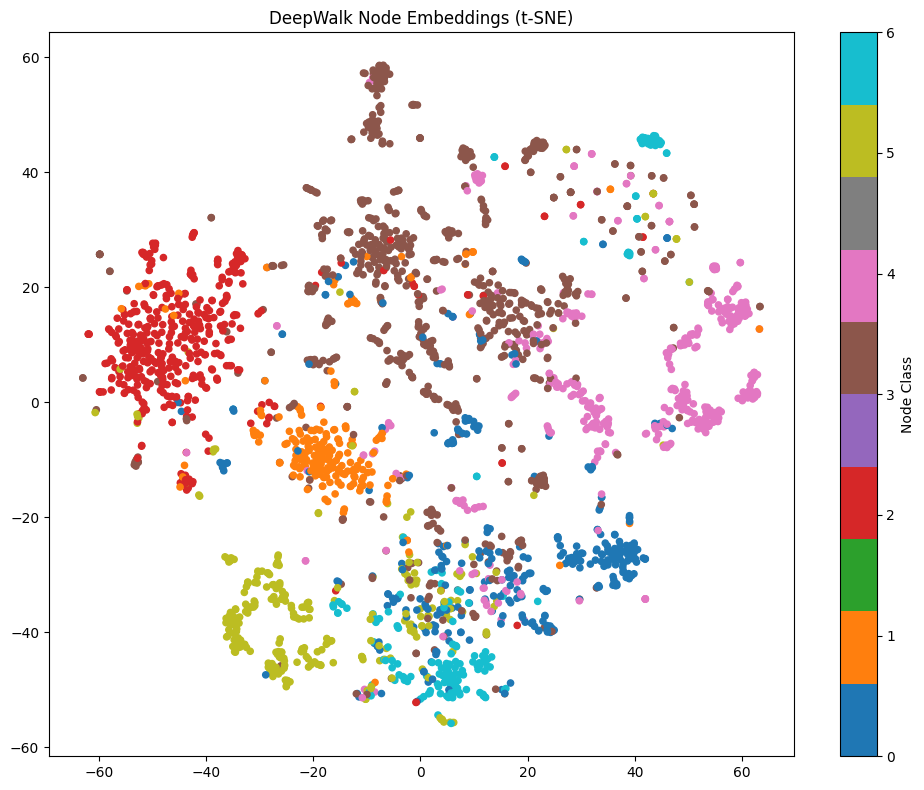

DeepWalk embeddings shape: (2708, 20)
DeepWalk embeddings are now assigned to data.x


In [13]:
# Add missing imports
import torch.nn.functional as F

# Example: Run on CORA dataset
if __name__ == "__main__":
    from torch_geometric.datasets import Planetoid

    # Load CORA dataset
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]

    # Run DeepWalk
    node_embeddings = run_deepwalk_on_dataset(data)

    # Convert to PyTorch tensor for use with GNN
    DW_node_features = torch.tensor(node_embeddings, dtype=torch.float)

    # Replace original features with DeepWalk embeddings
    original_x = data.x.clone()  # Save original features
    #data.x = node_features

    print(f"DeepWalk embeddings shape: {node_embeddings.shape}")
    print("DeepWalk embeddings are now assigned to data.x")

# Graph Neural Networks

## Graph Convolutional Networks

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [15]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [16]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Epoch: 010, Loss: 0.8183, Train: 0.9857, Val: 0.7760, Test: 0.7780
Epoch: 020, Loss: 0.2100, Train: 1.0000, Val: 0.7780, Test: 0.8000
Epoch: 030, Loss: 0.0862, Train: 1.0000, Val: 0.7740, Test: 0.7970
Epoch: 040, Loss: 0.0666, Train: 1.0000, Val: 0.7740, Test: 0.7900
Epoch: 050, Loss: 0.0450, Train: 1.0000, Val: 0.7840, Test: 0.8020
Epoch: 060, Loss: 0.0307, Train: 1.0000, Val: 0.7760, Test: 0.8010
Epoch: 070, Loss: 0.0404, Train: 1.0000, Val: 0.7640, Test: 0.7960
Epoch: 080, Loss: 0.0708, Train: 1.0000, Val: 0.7660, Test: 0.7950
Epoch: 090, Loss: 0.0628, Train: 1.0000, Val: 0.7640, Test: 0.7930
Epoch: 100, Loss: 0.0738, Train: 1.0000, Val: 0.7660, Test: 0.7930
Epoch: 110, Loss: 0.0437, Train: 1.0000, Val: 0.7600, Test: 0.7950
Epoch: 120, Loss: 0.0323, Train: 1.0000, Val: 0.7660, Test: 0.7930
Epoch: 130, Loss: 0.0390, Train: 1.0000, Val: 0.7680, Test: 0.8000
Epoch: 140, Loss: 0.0468, Train: 1.0000, Val: 0.7660, Test: 0.7970
Epoch: 150, Loss: 0.0280, Train: 1.0000, Val: 0.7640, Test: 0.

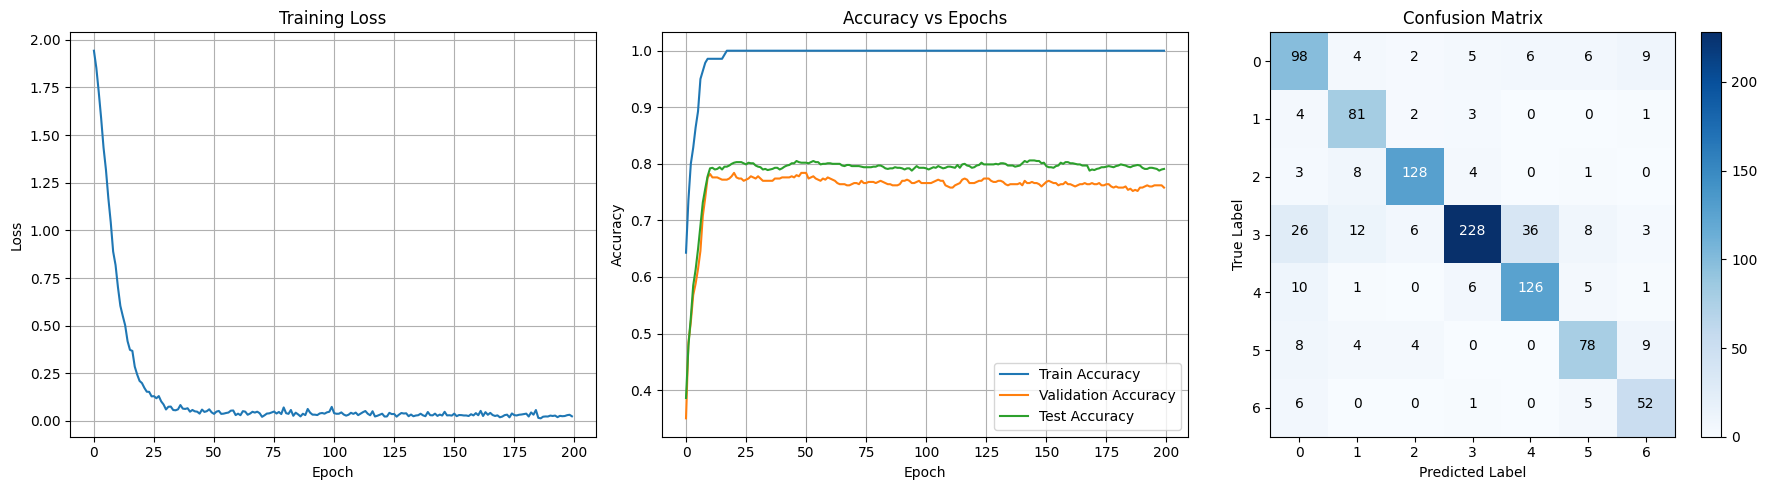

=== GCN Performance Summary ===
Best Test Accuracy: 0.8060 (Epoch 144)
Final Test Accuracy: 0.7910
Best Validation Accuracy: 0.7840 (Epoch 21)


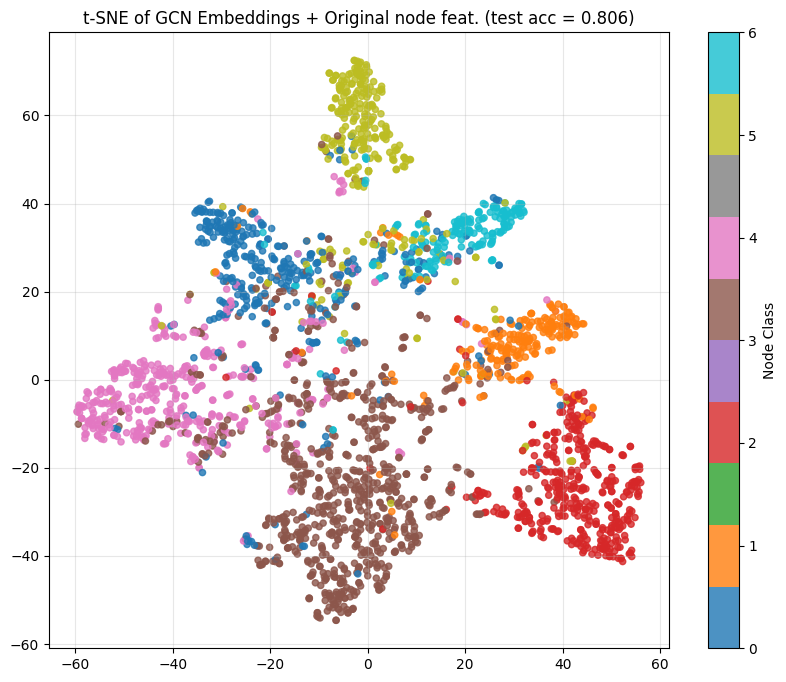

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from torch_geometric.nn import GCNConv



# Define lists to store metrics
train_losses = []
train_accs = []
val_accs = []
test_accs = []

# Redefine the train function to collect losses with updated model call
def train():
    model.train()
    optimizer.zero_grad()
    # Pass x and edge_index separately
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Redefine the test function with updated model call
def test():
    model.eval()
    # Pass x and edge_index separately
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs, pred

# Set up the model and optimizer with correct parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine proper dimensions from data
in_channels = data.x.shape[1]  # Input dimension from node features
hidden_channels = 16  # Hidden dimension as specified
out_channels = data.num_classes if hasattr(data, 'num_classes') else len(torch.unique(data.y))  # Number of classes

# Initialize the model with proper dimensions
model = GCN(in_channels, hidden_channels, out_channels).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop with metrics collection
for epoch in range(1, 201):
    loss = train()
    train_losses.append(loss)

    accs, pred = test()
    train_accs.append(accs[0])
    val_accs.append(accs[1])
    test_accs.append(accs[2])

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}')

# Final test accuracy
print("Final test acc =", test_accs[-1])

# Create confusion matrix for test data
final_pred = pred.cpu().numpy()
final_y = data.y.cpu().numpy()
cm = confusion_matrix(final_y[data.test_mask.cpu()], final_pred[data.test_mask.cpu()])

# Get the number of classes
num_classes = len(np.unique(final_y))

# Visualize the results
plt.figure(figsize=(18, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Confusion Matrix
plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.arange(num_classes)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations in the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('gcn_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize the node embeddings using t-SNE
def visualize_embeddings(model, data, test_acc=None):
    # Set model to evaluation mode
    model.eval()

    # Get embeddings
    with torch.no_grad():
        # Use the updated model call format
        out = model(data.x, data.edge_index)

    # Convert to numpy and apply t-SNE
    z = out.detach().cpu().numpy()
    z_tsne = TSNE(n_components=2, random_state=42).fit_transform(z)

    # Plot the t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(
        z_tsne[:, 0],
        z_tsne[:, 1],
        c=data.y.cpu(),
        cmap='tab10',
        s=20,
        alpha=0.8
    )

    # Add title with test accuracy if provided
    if test_acc is not None:
        plt.title(f"t-SNE of GCN Embeddings + Original node feat. (test acc = {np.round(test_acc, 3)})")
    else:
        plt.title("t-SNE of GCN Embeddings")

    plt.colorbar(label="Node Class")
    plt.grid(True, alpha=0.3)
    plt.savefig('gcn_tsne.png', dpi=300, bbox_inches='tight')
    plt.show()

# Print a summary of model performance
print("=== GCN Performance Summary ===")
print(f"Best Test Accuracy: {max(test_accs):.4f} (Epoch {test_accs.index(max(test_accs))+1})")
print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
print(f"Best Validation Accuracy: {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")

# Visualize embeddings with the best test accuracy
from sklearn.manifold import TSNE
visualize_embeddings(model, data, max(test_accs))

In [18]:
out.shape

NameError: name 'out' is not defined

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Create trivial node features
def create_trivial_features(data, feature_type='one-hot'):
    num_nodes = data.num_nodes

    if feature_type == 'one-hot':
        # One-hot encoding: Each node gets a unique one-hot vector
        x = torch.eye(num_nodes)
    elif feature_type == 'random':
        # Random features: Each node gets a random feature vector
        feature_dim = 64  # You can adjust this dimension
        x = torch.randn(num_nodes, feature_dim)
    elif feature_type == 'constant':
        # Constant features: All nodes get the same feature vector
        x = torch.ones(num_nodes, 1)
    elif feature_type == 'degree':
        # Degree-based features: Features based on node degrees
        edge_index = data.edge_index
        degree = torch.zeros(num_nodes)
        for i in range(edge_index.shape[1]):
            degree[edge_index[0, i]] += 1
        x = degree.view(-1, 1)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

    return x

# Define lists to store metrics
train_losses = []
train_accs = []
val_accs = []
test_accs = []

# Redefine the train function to collect losses
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Redefine the test function to return predictions for confusion matrix
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs, pred

# Main experiment code
def run_experiment(feature_type='one-hot'):
    global data, model, optimizer

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create trivial features and replace original features
    original_x = data.x.clone()  # Save original features for comparison
    if feature_type == "deepwalk":
        data.x = DW_node_features
    else:
        data.x = create_trivial_features(data, feature_type=feature_type)

    # Move data to device
    data = data.to(device)

    # Initialize GCN model
    in_channels = data.x.shape[1]
    hidden_channels = 16
    out_channels = data.num_classes if hasattr(data, 'num_classes') else len(torch.unique(data.y))

    model = GCN(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Reset metrics storage
    train_losses.clear()
    train_accs.clear()
    val_accs.clear()
    test_accs.clear()

    # Training loop with metrics collection
    for epoch in range(1, 201):
        loss = train()
        train_losses.append(loss)

        accs, pred = test()
        train_accs.append(accs[0])
        val_accs.append(accs[1])
        test_accs.append(accs[2])

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}')

    # Final test accuracy
    print(f"Final test acc ({feature_type} features) = {test_accs[-1]:.4f}")

    # Create confusion matrix for test data
    final_pred = pred.cpu().numpy()
    final_y = data.y.cpu().numpy()
    cm = confusion_matrix(final_y[data.test_mask.cpu()], final_pred[data.test_mask.cpu()])

    # Get the number of classes
    num_classes = len(np.unique(final_y))

    # Visualize the results
    plt.figure(figsize=(18, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title(f'Training Loss ({feature_type} features)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot 2: Accuracies
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'Accuracy vs Epochs ({feature_type} features)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({feature_type} features)')
    plt.colorbar()
    classes = np.arange(num_classes)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations in the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig(f'gcn_performance_{feature_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print a summary of model performance
    print(f"=== GCN Performance Summary ({feature_type} features) ===")
    print(f"Best Test Accuracy: {max(test_accs):.4f} (Epoch {test_accs.index(max(test_accs))+1})")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Best Validation Accuracy: {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")

    # Restore original features
    data.x = original_x
    data = data.to('cpu')  # Move back to CPU to save memory
    return model

# Example usage:
model = run_experiment('one-hot')
# You can also try:
# run_experiment('random')
# run_experiment('constant')
# run_experiment('degree')
# run_experiment('deepwalk')


model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

z = out.detach().cpu().numpy()
z_tsne = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=data.y.cpu(), cmap='tab10', s=15)

if 'test_acc' in globals():
    plt.title(f"t-SNE of GCN Embeddings + One-Hot feat. (test acc = {np.round(test_accs[-1], 3)})")
else:
    plt.title("t-SNE of GCN Embeddings")

plt.colorbar()
plt.show()


Epoch: 010, Loss: 1.7239, Train: 0.9786, Val: 0.4860, Test: 0.5240
Epoch: 020, Loss: 1.3350, Train: 0.9929, Val: 0.4940, Test: 0.5290
Epoch: 030, Loss: 0.9423, Train: 0.9929, Val: 0.5340, Test: 0.5490
Epoch: 040, Loss: 0.6031, Train: 1.0000, Val: 0.5440, Test: 0.5720
Epoch: 050, Loss: 0.4410, Train: 1.0000, Val: 0.5600, Test: 0.5820
Epoch: 060, Loss: 0.2865, Train: 1.0000, Val: 0.5780, Test: 0.5970
Epoch: 070, Loss: 0.2405, Train: 1.0000, Val: 0.5900, Test: 0.6070
Epoch: 080, Loss: 0.2201, Train: 1.0000, Val: 0.5720, Test: 0.5930
Epoch: 090, Loss: 0.2291, Train: 1.0000, Val: 0.5680, Test: 0.5900
Epoch: 100, Loss: 0.2034, Train: 1.0000, Val: 0.5780, Test: 0.5950
Epoch: 110, Loss: 0.1852, Train: 1.0000, Val: 0.5820, Test: 0.6070
Epoch: 120, Loss: 0.1649, Train: 1.0000, Val: 0.5760, Test: 0.5970
Epoch: 130, Loss: 0.1617, Train: 1.0000, Val: 0.5740, Test: 0.6040
Epoch: 140, Loss: 0.1322, Train: 1.0000, Val: 0.5900, Test: 0.6220
Epoch: 150, Loss: 0.1456, Train: 1.0000, Val: 0.5740, Test: 0.

In [ ]:
def visualize_embeddings(model, data, test_acc=None):
    """
    Visualize GCN embeddings using t-SNE

    Args:
        model: trained GCN model
        data: PyTorch Geometric Data object with graph
        test_acc: Test accuracy to display in title (optional)
    """
    # Set model to evaluation mode
    model.eval()

    # Get embeddings
    with torch.no_grad():
        # Pass x and edge_index separately
        out = model(data.x, data.edge_index)

    # Convert to numpy and apply t-SNE
    z = out.detach().cpu().numpy()
    z_tsne = TSNE(n_components=2, random_state=42).fit_transform(z)

    # Plot the t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        z_tsne[:, 0],
        z_tsne[:, 1],
        c=data.y.cpu(),
        cmap='tab10',
        s=15,
        alpha=0.8
    )

    # Add title with test accuracy if provided
    if test_acc is not None:
        plt.title(f"t-SNE of GCN Embeddings (test acc = {np.round(test_acc, 3)})")
    else:
        plt.title("t-SNE of GCN Embeddings")

    # Add colorbar and labels
    cbar = plt.colorbar(scatter)
    cbar.set_label("Node Class")

    # Add grid for better readability
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

z = out.detach().cpu().numpy()
z_tsne = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=data.y.cpu(), cmap='tab10', s=15)

if 'test_acc' in globals():
    plt.title(f"t-SNE of GCN Embeddings + One-Hot feat. (test acc = {np.round(test_accs[-1], 3)})")
else:
    plt.title("t-SNE of GCN Embeddings")

plt.colorbar()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2708x1433 and 2708x16)

DeepWalk features prepared with shape: torch.Size([2708, 20])
Using DeepWalk features with shape: torch.Size([2708, 20])
Feature shape before training: torch.Size([2708, 20])
GCN model dimensions: in=20, hidden=16, out=7
Epoch: 010, Loss: 1.9154, Train: 0.1429, Val: 0.0900, Test: 0.0830
Epoch: 020, Loss: 1.8661, Train: 0.2643, Val: 0.1360, Test: 0.1470
Epoch: 030, Loss: 1.8214, Train: 0.2857, Val: 0.1660, Test: 0.1760
Epoch: 040, Loss: 1.7422, Train: 0.3786, Val: 0.1420, Test: 0.1600
Epoch: 050, Loss: 1.6794, Train: 0.4286, Val: 0.1460, Test: 0.1750
Epoch: 060, Loss: 1.6350, Train: 0.4714, Val: 0.1540, Test: 0.1630
Epoch: 070, Loss: 1.6071, Train: 0.4929, Val: 0.1680, Test: 0.1680
Epoch: 080, Loss: 1.5044, Train: 0.5286, Val: 0.1740, Test: 0.1700
Epoch: 090, Loss: 1.5108, Train: 0.5571, Val: 0.1700, Test: 0.1720
Epoch: 100, Loss: 1.4343, Train: 0.6357, Val: 0.1800, Test: 0.1800
Epoch: 110, Loss: 1.3866, Train: 0.6214, Val: 0.1700, Test: 0.1760
Epoch: 120, Loss: 1.3699, Train: 0.6643, V

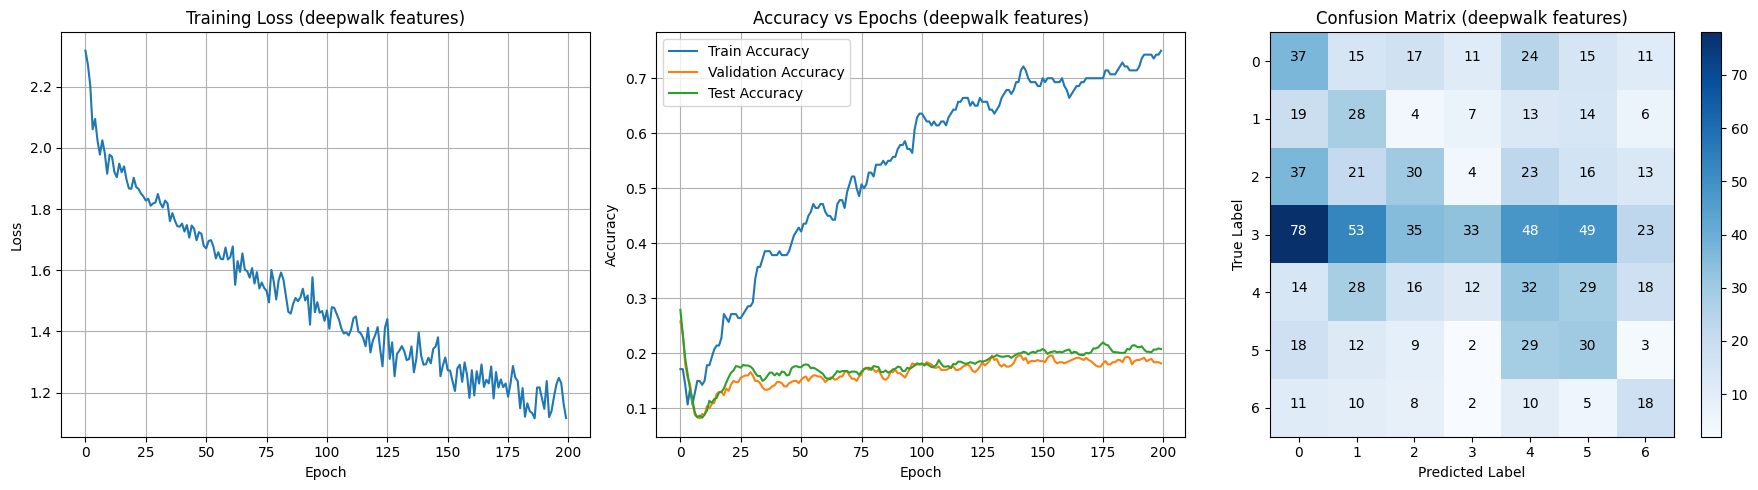

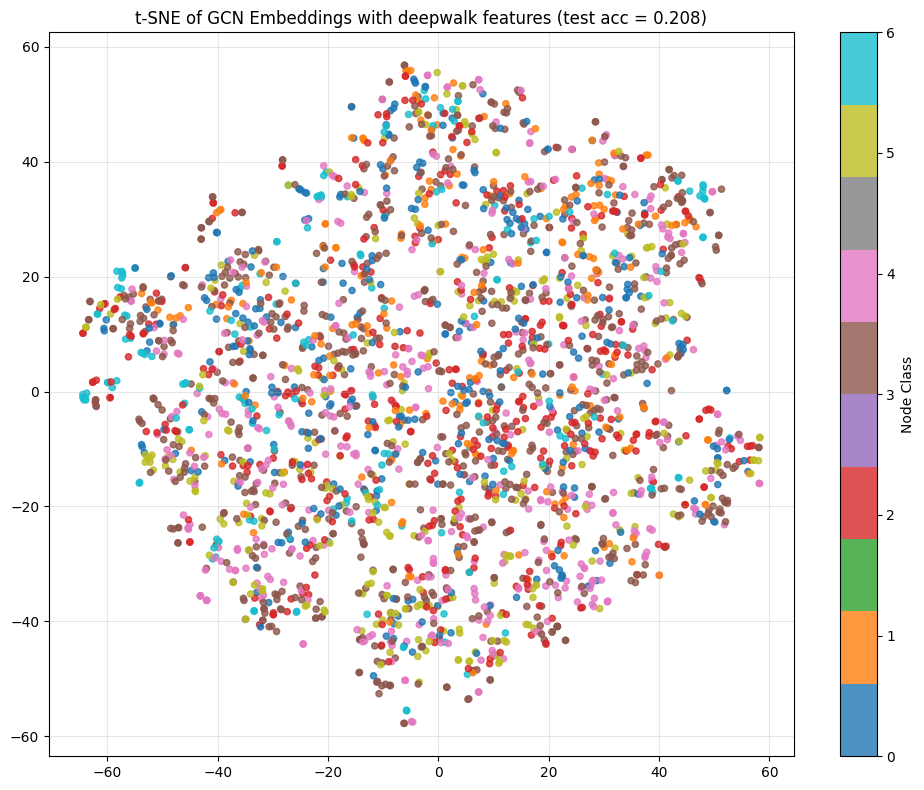

=== GCN Performance Summary (deepwalk features) ===
Best Test Accuracy: 0.2790 (Epoch 1)
Final Test Accuracy: 0.2080
Best Validation Accuracy: 0.2580 (Epoch 1)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Create trivial node features
def create_trivial_features(data, feature_type='one-hot'):
    num_nodes = data.num_nodes

    if feature_type == 'one-hot':
        # One-hot encoding: Each node gets a unique one-hot vector
        x = torch.eye(num_nodes)
    elif feature_type == 'random':
        # Random features: Each node gets a random feature vector
        feature_dim = 64  # You can adjust this dimension
        x = torch.randn(num_nodes, feature_dim)
    elif feature_type == 'constant':
        # Constant features: All nodes get the same feature vector
        x = torch.ones(num_nodes, 1)
    elif feature_type == 'degree':
        # Degree-based features: Features based on node degrees
        edge_index = data.edge_index
        degree = torch.zeros(num_nodes)
        for i in range(edge_index.shape[1]):
            degree[edge_index[0, i]] += 1
        x = degree.view(-1, 1)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

    return x

# Define lists to store metrics
train_losses = []
train_accs = []
val_accs = []
test_accs = []

# Redefine the train function to collect losses
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Redefine the test function to return predictions for confusion matrix
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs, pred

# Main experiment code
def run_experiment(feature_type='one-hot'):
    global data, model, optimizer, train_losses, train_accs, val_accs, test_accs

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create trivial features and replace original features
    original_x = data.x.clone() if hasattr(data, 'x') else None  # Save original features for comparison

    if feature_type == "deepwalk":
        if 'DW_node_features' in globals():
            print(f"Using DeepWalk features with shape: {DW_node_features.shape}")
            data.x = DW_node_features
        else:
            print("DeepWalk features not found. Using random features instead.")
            data.x = create_trivial_features(data, feature_type='random')
    else:
        data.x = create_trivial_features(data, feature_type=feature_type)

    print(f"Feature shape before training: {data.x.shape}")

    # Move data to device
    data = data.to(device)

    # Initialize GCN model
    in_channels = data.x.shape[1]
    hidden_channels = 16
    out_channels = data.num_classes if hasattr(data, 'num_classes') else len(torch.unique(data.y))

    print(f"GCN model dimensions: in={in_channels}, hidden={hidden_channels}, out={out_channels}")

    model = GCN(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Reset metrics storage
    train_losses.clear()
    train_accs.clear()
    val_accs.clear()
    test_accs.clear()

    # Training loop with metrics collection
    for epoch in range(1, 201):
        loss = train()
        train_losses.append(loss)

        accs, pred = test()
        train_accs.append(accs[0])
        val_accs.append(accs[1])
        test_accs.append(accs[2])

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}')

    # Final test accuracy
    print(f"Final test acc ({feature_type} features) = {test_accs[-1]:.4f}")

    # Create confusion matrix for test data
    final_pred = pred.cpu().numpy()
    final_y = data.y.cpu().numpy()
    cm = confusion_matrix(final_y[data.test_mask.cpu()], final_pred[data.test_mask.cpu()])

    # Get the number of classes
    num_classes = len(np.unique(final_y))

    # Visualize the results
    plt.figure(figsize=(18, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title(f'Training Loss ({feature_type} features)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot 2: Accuracies
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'Accuracy vs Epochs ({feature_type} features)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({feature_type} features)')
    plt.colorbar()
    classes = np.arange(num_classes)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations in the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig(f'gcn_performance_{feature_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualize embeddings
    visualize_embeddings(model, data, feature_type, test_accs[-1])

    # Print a summary of model performance
    print(f"=== GCN Performance Summary ({feature_type} features) ===")
    print(f"Best Test Accuracy: {max(test_accs):.4f} (Epoch {test_accs.index(max(test_accs))+1})")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Best Validation Accuracy: {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")

    # Restore original features if necessary
    if original_x is not None:
        data.x = original_x
    data = data.to('cpu')  # Move back to CPU to save memory

    return model

# Function to visualize embeddings
def visualize_embeddings(model, data, feature_type, test_acc):
    model.eval()
    with torch.no_grad():
        # Make sure the model and data are on the same device
        if next(model.parameters()).device != data.x.device:
            model = model.to(data.x.device)

        # Get embeddings
        out = model(data.x, data.edge_index)

    # Convert to numpy for t-SNE
    z = out.detach().cpu().numpy()
    y = data.y.cpu().numpy()

    # Apply t-SNE
    z_tsne = TSNE(n_components=2, random_state=42).fit_transform(z)

    # Plot results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap='tab10', s=20, alpha=0.8)
    plt.title(f"t-SNE of GCN Embeddings with {feature_type} features (test acc = {np.round(test_acc, 3)})")
    plt.colorbar(scatter, label="Node Class")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'gcn_tsne_{feature_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

# To use DeepWalk embeddings, first convert them to a tensor
def set_deepwalk_features(X):
    """
    Convert DeepWalk embeddings to a PyTorch tensor and make them globally available

    Args:
        X: NumPy array of DeepWalk embeddings [num_nodes, embedding_dim]
    """
    global DW_node_features
    DW_node_features = torch.tensor(X, dtype=torch.float)
    print(f"DeepWalk features prepared with shape: {DW_node_features.shape}")

# Example usage:

# First, set DeepWalk features if you have them
set_deepwalk_features(X)  # X is your DeepWalk embedding matrix

# Then run experiments with different feature types
#model_one_hot = run_experiment('one-hot')
#model_random = run_experiment('random')
#model_degree = run_experiment('degree')
model_deepwalk = run_experiment('deepwalk')


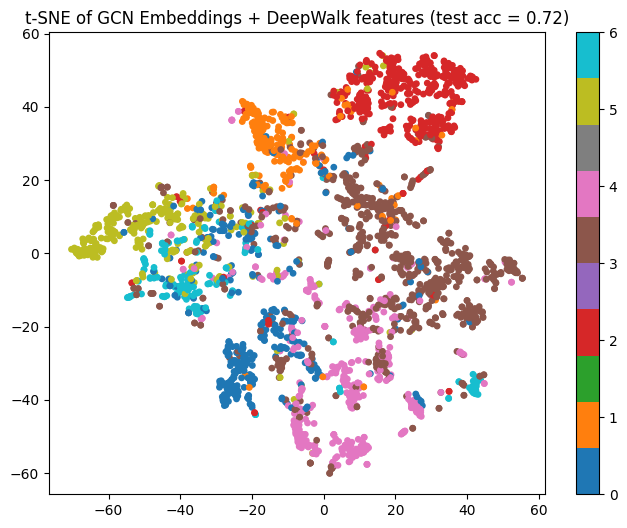

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

z = out.detach().cpu().numpy()
z_tsne = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=data.y.cpu(), cmap='tab10', s=15)

if 'test_acc' in globals():
    plt.title(f"t-SNE of GCN Embeddings + DeepWalk features (test acc = {np.round(test_accs[-1], 3)})")
else:
    plt.title("t-SNE of GCN Embeddings")

plt.colorbar()
plt.show()

## Graph Attention Networks

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.6, train=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GAT(dataset.num_features, 16, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

In [ ]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
model.eval()
out = model(data)
z = out.detach().cpu().numpy()
z_tsne = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE of GAT Embeddings")
plt.colorbar()
plt.show()

## Graph Sage

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

In [ ]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
model.eval()
out = model(data)
z = out.detach().cpu().numpy()
z_tsne = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE of Graph Sage Embeddings")
plt.colorbar()
plt.show()